In [91]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans

In [92]:
data=pd.read_csv("OnlineRetail.csv")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [93]:
#checking data types
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [94]:
#converting date into proper format
data.InvoiceDate=pd.to_datetime(data.InvoiceDate)

In [95]:
data.Country.value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

### In this exercise, we are only concerned about the customers in U. So, we remove the data from other countries.

In [96]:
data=data.loc[data["Country"]=="United Kingdom"] #removing other countries
data.Country.value_counts() #confirming the removal

United Kingdom    495478
Name: Country, dtype: int64

## Finding customer Recency

In [97]:
last_purchase=data.groupby("CustomerID")["InvoiceDate"].max()
days_since_purchase=(last_purchase.max()-last_purchase).dt.days
days_since_purchase

CustomerID
12346.0    325
12747.0      1
12748.0      0
12749.0      3
12820.0      2
          ... 
18280.0    277
18281.0    180
18282.0      7
18283.0      3
18287.0     42
Name: InvoiceDate, Length: 3950, dtype: int64

In [98]:
user_data=pd.DataFrame(days_since_purchase).reset_index()
user_data.columns=['CustomerID', 'days_since_purchase']
user_data.head()

,CustomerID,days_since_purchase
0,12346.0,325
1,12747.0,1
2,12748.0,0
3,12749.0,3
4,12820.0,2


## Clustering customers into different bins

In [99]:
user_data.days_since_purchase.describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: days_since_purchase, dtype: float64

### The mean # of days since last purchse is 90 and the median is 49. We can split the customers based on the qurtiles or bin them into clusters. Let us cluster them here.

In [100]:
sse=[]

for k in range(1,10):
    clustering=KMeans(n_clusters=k)
    clustering.fit(user_data[["days_since_purchase"]])
    sse.append(clustering.inertia_)

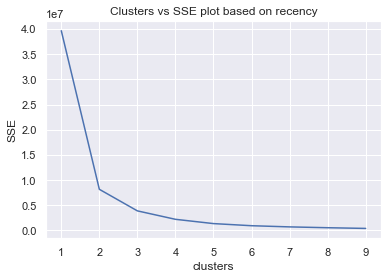

In [101]:
#plotting the sse based on number of clusters
sns.set()
sns.lineplot(x=range(1,10),y=sse)
plt.xlabel("clusters")
plt.ylabel("SSE")
plt.title("Clusters vs SSE plot based on recency")
plt.show()

### We select 3 clusters as the elbow occurs at k=3. Let us assign this value to the customers

In [102]:
clustering=KMeans(n_clusters=3)
clustering.fit(user_data[["days_since_purchase"]])
user_data["Recency"]=clustering.predict(user_data[["days_since_purchase"]])
user_data

,CustomerID,days_since_purchase,Recency
0,12346.0,325,1
1,12747.0,1,0
2,12748.0,0,0
3,12749.0,3,0
4,12820.0,2,0
...,...,...,...
3945,18280.0,277,1
3946,18281.0,180,2
3947,18282.0,7,0
3948,18283.0,3,0


In [103]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [104]:
#Ordering the clusters
user_data=order_cluster("Recency","days_since_purchase",user_data,False)

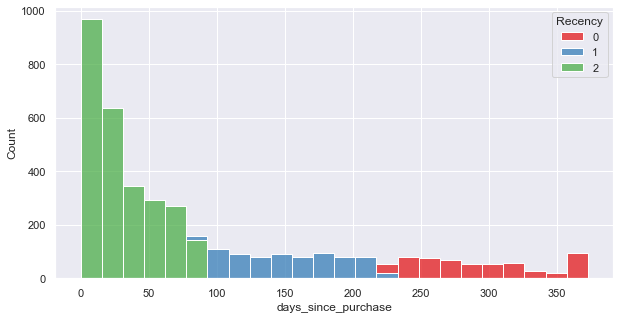

2    2651
1     735
0     564
Name: Recency, dtype: int64

In [128]:
figure(figsize=(10,5))
sns.histplot(data=user_data,x="days_since_purchase",hue="Recency",palette="Set1",multiple="stack")
plt.show()
user_data.Recency.value_counts()

### The users that bought most recently have a value of 2 and the users that bought a lot of time before are given a value of 0.

## Finding customer Frequency

In [107]:
num_times_purchased=pd.DataFrame(data.groupby('CustomerID').InvoiceDate.count().reset_index())
num_times_purchased.columns=["CustomerID","num_times_purchased"]
num_times_purchased.head()

,CustomerID,num_times_purchased
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [108]:
#adding it to user_data dataframe
user_data=pd.merge(user_data,num_times_purchased,on="CustomerID")
user_data.head()

In [110]:
#looking at how the data looks:
user_data["num_times_purchased"].describe()

count    3950.000000
mean       91.614684
std       220.557389
min         1.000000
25%        17.000000
50%        41.000000
75%       101.000000
max      7983.000000
Name: num_times_purchased, dtype: float64

### The mean number of purchases is 91 and median is 41. Again, splitting into different clusters this time based on frequency

In [111]:
sse=[]

for k in range(1,10):
    clustering=KMeans(n_clusters=k)
    clustering.fit(user_data[["num_times_purchased"]])
    sse.append(clustering.inertia_)

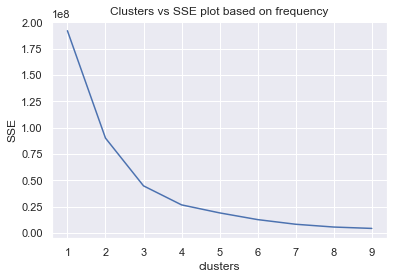

In [112]:
#plotting the sse based on number of clusters
sns.set()
sns.lineplot(x=range(1,10),y=sse)
plt.xlabel("clusters")
plt.ylabel("SSE")
plt.title("Clusters vs SSE plot based on frequency")
plt.show()

### There seems to be a sharp elbow at k=5. So, let us use 4 clusters for frequency.

In [114]:
clustering=KMeans(n_clusters=4)
clustering.fit(user_data[["num_times_purchased"]])
user_data["Frequency"]=clustering.predict(user_data[["num_times_purchased"]])
user_data.head()

,CustomerID,days_since_purchase,Recency,num_times_purchased,Frequency
0,12346.0,325,0,2,0
1,12829.0,321,0,12,0
2,12831.0,261,0,9,0
3,12834.0,282,0,18,0
4,12845.0,266,0,27,0


In [120]:
#Ordering the clusters
user_data=order_cluster("Frequency","num_times_purchased",user_data,True)

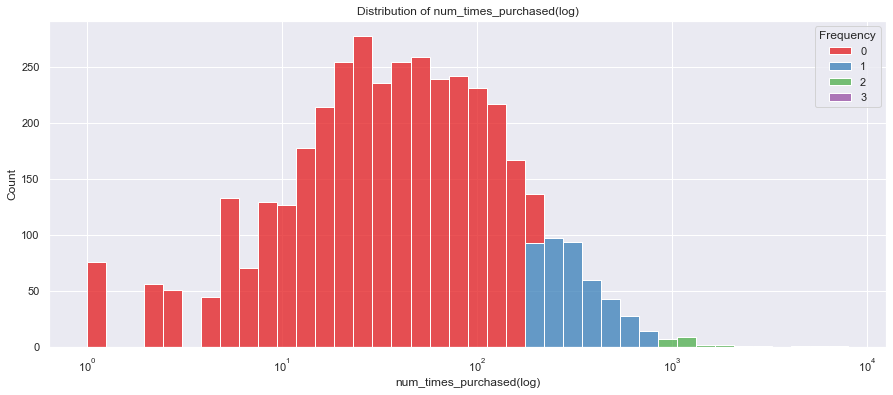

0    3496
1     429
2      22
3       3
Name: Frequency, dtype: int64

In [127]:
#plotting distribution based on clusters 
figure(figsize=(15,6))
sns.histplot(data=user_data,x="num_times_purchased",hue="Frequency",palette="Set1",multiple="stack",log_scale=True)
plt.xlabel("num_times_purchased(log)")
plt.title("Distribution of num_times_purchased(log)")
plt.show()
user_data.Frequency.value_counts()

### The distribution is shown in log sclae for better visualization. The most frequent purchases are having the highest value and the infrequent purchases have 0 as value. There are only 3 customers in the third cluster.

## Grouping by Monetary value

### To get the monetary value, the revenue is taken here by multiplying quantity and unit price.

In [131]:
data["Revenue"]=data["Quantity"]*data["UnitPrice"]

In [133]:
revenue_generated=pd.DataFrame(data.groupby('CustomerID').Revenue.sum().reset_index())
revenue_generated.columns=["CustomerID","revenue_generated"]
revenue_generated.head()

,CustomerID,revenue_generated
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [134]:
#adding it to user_data dataframe
user_data=pd.merge(user_data,revenue_generated,on="CustomerID")
user_data.head()

,CustomerID,days_since_purchase,Recency,num_times_purchased,Frequency,revenue_generated
0,12346.0,325,0,2,0,0.00
1,12829.0,321,0,12,0,253.05
2,12831.0,261,0,9,0,215.05
3,12834.0,282,0,18,0,312.38
4,12845.0,266,0,27,0,354.09


In [135]:
#looking at how the data looks:
user_data["revenue_generated"].describe()

count      3950.000000
mean       1713.385669
std        6548.608224
min       -4287.630000
25%         282.255000
50%         627.060000
75%        1521.782500
max      256438.490000
Name: revenue_generated, dtype: float64

### The mean amount spent is 1700 and the median is 600. There are some customers who have spent a negative amount which might need some investigation.

In [136]:
sse=[]

for k in range(1,10):
    clustering=KMeans(n_clusters=k)
    clustering.fit(user_data[["revenue_generated"]])
    sse.append(clustering.inertia_)

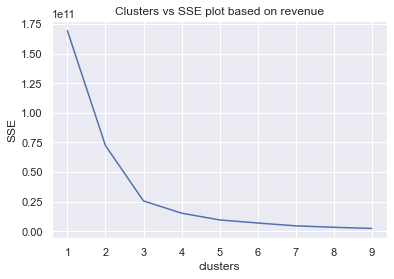

In [137]:
#plotting the sse based on number of clusters
sns.set()
sns.lineplot(x=range(1,10),y=sse)
plt.xlabel("clusters")
plt.ylabel("SSE")
plt.title("Clusters vs SSE plot based on revenue")
plt.show()

### Since there is an elbow at 3, we will select 3 clusters. The customers who spent more money will haave a higher cluster number.

In [139]:
clustering=KMeans(n_clusters=4)
clustering.fit(user_data[["revenue_generated"]])
user_data["Monetary"]=clustering.predict(user_data[["revenue_generated"]])
user_data.head()

,CustomerID,days_since_purchase,Recency,num_times_purchased,Frequency,revenue_generated,Monetary
0,12346.0,325,0,2,0,0.00,0
1,12829.0,321,0,12,0,253.05,0
2,12831.0,261,0,9,0,215.05,0
3,12834.0,282,0,18,0,312.38,0
4,12845.0,266,0,27,0,354.09,0


In [141]:
#Ordering the clusters
user_data=order_cluster("Monetary","revenue_generated",user_data,True)

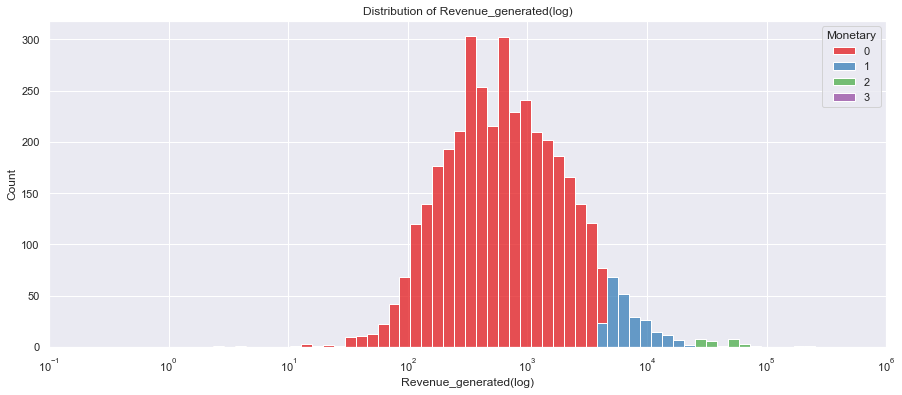

0    3687
1     234
2      27
3       2
Name: Monetary, dtype: int64

In [154]:
#plotting distribution based on clusters 
temp_for_plotting=user_data.loc[user_data["revenue_generated"]>0]
figure(figsize=(15,6))
sns.histplot(data=temp_for_plotting,x="revenue_generated",hue="Monetary",palette="Set1",multiple="stack",log_scale=True)
plt.xlabel("Revenue_generated(log)")
plt.title("Distribution of Revenue_generated(log)")
plt.xlim(0.1,1000000)
plt.show()
user_data.Monetary.value_counts()

### There are 4 clusters based on revenue generated. The clusters with lower values are to show lower revenue and higher values show higher revenue

In [158]:
#Combining the Recency, Frequency and Monetary value to a single score,
user_data["net_score"]=user_data["Recency"]+user_data["Frequency"]+user_data["Monetary"]
user_data["net_score"].value_counts()

2    2153
1     723
0     559
3     326
4     152
5      27
6       7
7       3
Name: net_score, dtype: int64

### The maximum possible net score is 8 and minimum possible net score is 0. But, we do not have anyone with a score of 8. The net score ranges from 0 to 7.

In [159]:
user_data["Segment"]="Low-Value"
user_data.loc[user_data["net_score"]>2,"Segment"]="Mid-Value"
user_data.loc[user_data["net_score"]>4,"Segment"]="High-Value"

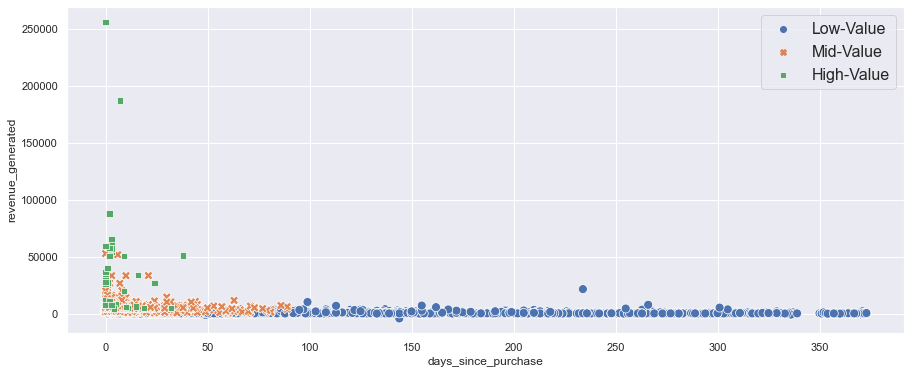

In [181]:
figure(figsize=(15,6))
sns.scatterplot(data=user_data,x="days_since_purchase",y="revenue_generated",hue="Segment",s=80,style="Segment")
plt.legend(loc='best', prop={'size': 16})
plt.show()

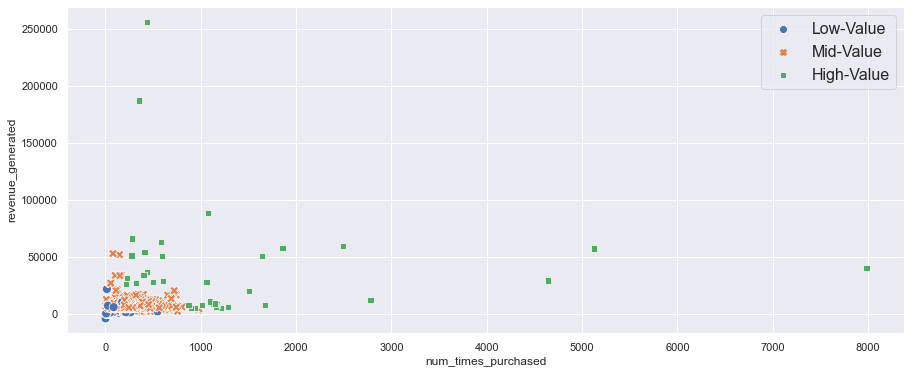

In [182]:
figure(figsize=(15,6))
sns.scatterplot(data=user_data,x="num_times_purchased",y="revenue_generated",hue="Segment",s=80,style="Segment")
plt.legend(loc='best', prop={'size': 16})
plt.show()

### The segmentation seems to work well in grouping customers in regards to their spending, frequency and recency. 

### Such segmentation can be used to target customers in specific segments and run trials to increase revenue and profit.